# **YoloV3(TensorFlow) 모델 실습**

## **1. 사전 환경 세팅**

### **1-1. TensorFlow 정상 설치 확인**

In [1]:
!conda env create -f conda-gpu.yml
!conda activate yolov3-tf2-gpu

/root/miniconda3/lib/python3.12/argparse.py:2006: FutureWarning: `remote_definition` is deprecated and will be removed in 25.9. Use `conda env create --file=URL` instead.
  action(self, namespace, argument_values, option_string)

CondaValueError: prefix already exists: /root/miniconda3/envs/yolov3-tf2-gpu


CondaError: Run 'conda init' before 'conda activate'



In [2]:
%cd /workspace

/workspace


In [3]:
!pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.12.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached jax-0.4.30-py3-none-any.whl.metadata (22 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64

In [4]:
!ls

import tensorflow as tf
tf.__version__

Miniconda3-latest-Linux-x86_64.sh    code      yolov3-tf2
Miniconda3-latest-Linux-x86_64.sh.1  datasets  yolov5


2024-11-27 04:13:20.968236: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 04:13:20.998006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 04:13:21.450742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

ImportError: _multiarray_umath failed to import

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

'2.12.0'

### **1-2. Darknet weight 파일로 변환 처리**

In [5]:
!pip install opencv-python lxml tqdm

  Using cached lxml-5.3.0-cp39-cp39-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
Using cached lxml-5.3.0-cp39-cp39-manylinux_2_28_x86_64.whl (5.0 MB)


In [6]:
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf
!python convert.py --weights ./data/yolov3-tiny.weights --output ./checkpoints/yolov3-tiny.tf --tiny

python: can't open file '/workspace/convert.py': [Errno 2] No such file or directory
python: can't open file '/workspace/convert.py': [Errno 2] No such file or directory


In [7]:
%cd yolov3-tf2/

/workspace/yolov3-tf2


## **2. Detector 정의**

In [8]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

In [9]:
# absl 라이브러리를 사용한 커맨드라인 플래그(옵션) 정의
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

# 앱 초기화 및 플래그 파싱
app._run_init(['yolov3'], app.parse_flags_with_usage)

['yolov3']

In [10]:
# GPU 설정을 통해 사용 가능한 GPU 장치를 확인하고, GPU 메모리 활성화
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-11-27 04:13:23.367046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 04:13:23.422372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 04:13:23.424545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## **3. pre-trained weight를 활용한 detection 테스트**

In [11]:
# 테스트할 이미지 입력 경로 설정
FLAGS.image = 'data/meme.jpg'

# YOLOv3 기본 또는 tiny 모델 파이프라인 선택
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
# 모델 weight 파일 로드
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

# 클래스 이름 로드
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

# 입력 이미지 로드
img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

# 이미지 전처리
img = tf.expand_dims(img_raw, 0) # 이미지 차원 확장 (배치 차원 추가)
img = transform_images(img, FLAGS.size) # 이미지를 모델 입력 크기에 맞게 리사이즈 및 정규화

2024-11-27 04:13:23.441210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 04:13:23.443367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 04:13:23.445343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# 모델 예측 수행
t1 = time.time() # 시작 시간 기록
boxes, scores, classes, nums = yolo(img) # 이미지에서 객체 탐지 수행
t2 = time.time() # 종료 시간 기록
logging.info('time: {}'.format(t2 - t1))

# 탐지된 객체 정보 출력
logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

2024-11-27 04:13:25.677237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906
2024-11-27 04:13:25.813166: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-27 04:13:25.813438: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-27 04:13:25.813454: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-11-27 04:13:25.813722: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-27 04:13:25.813803: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

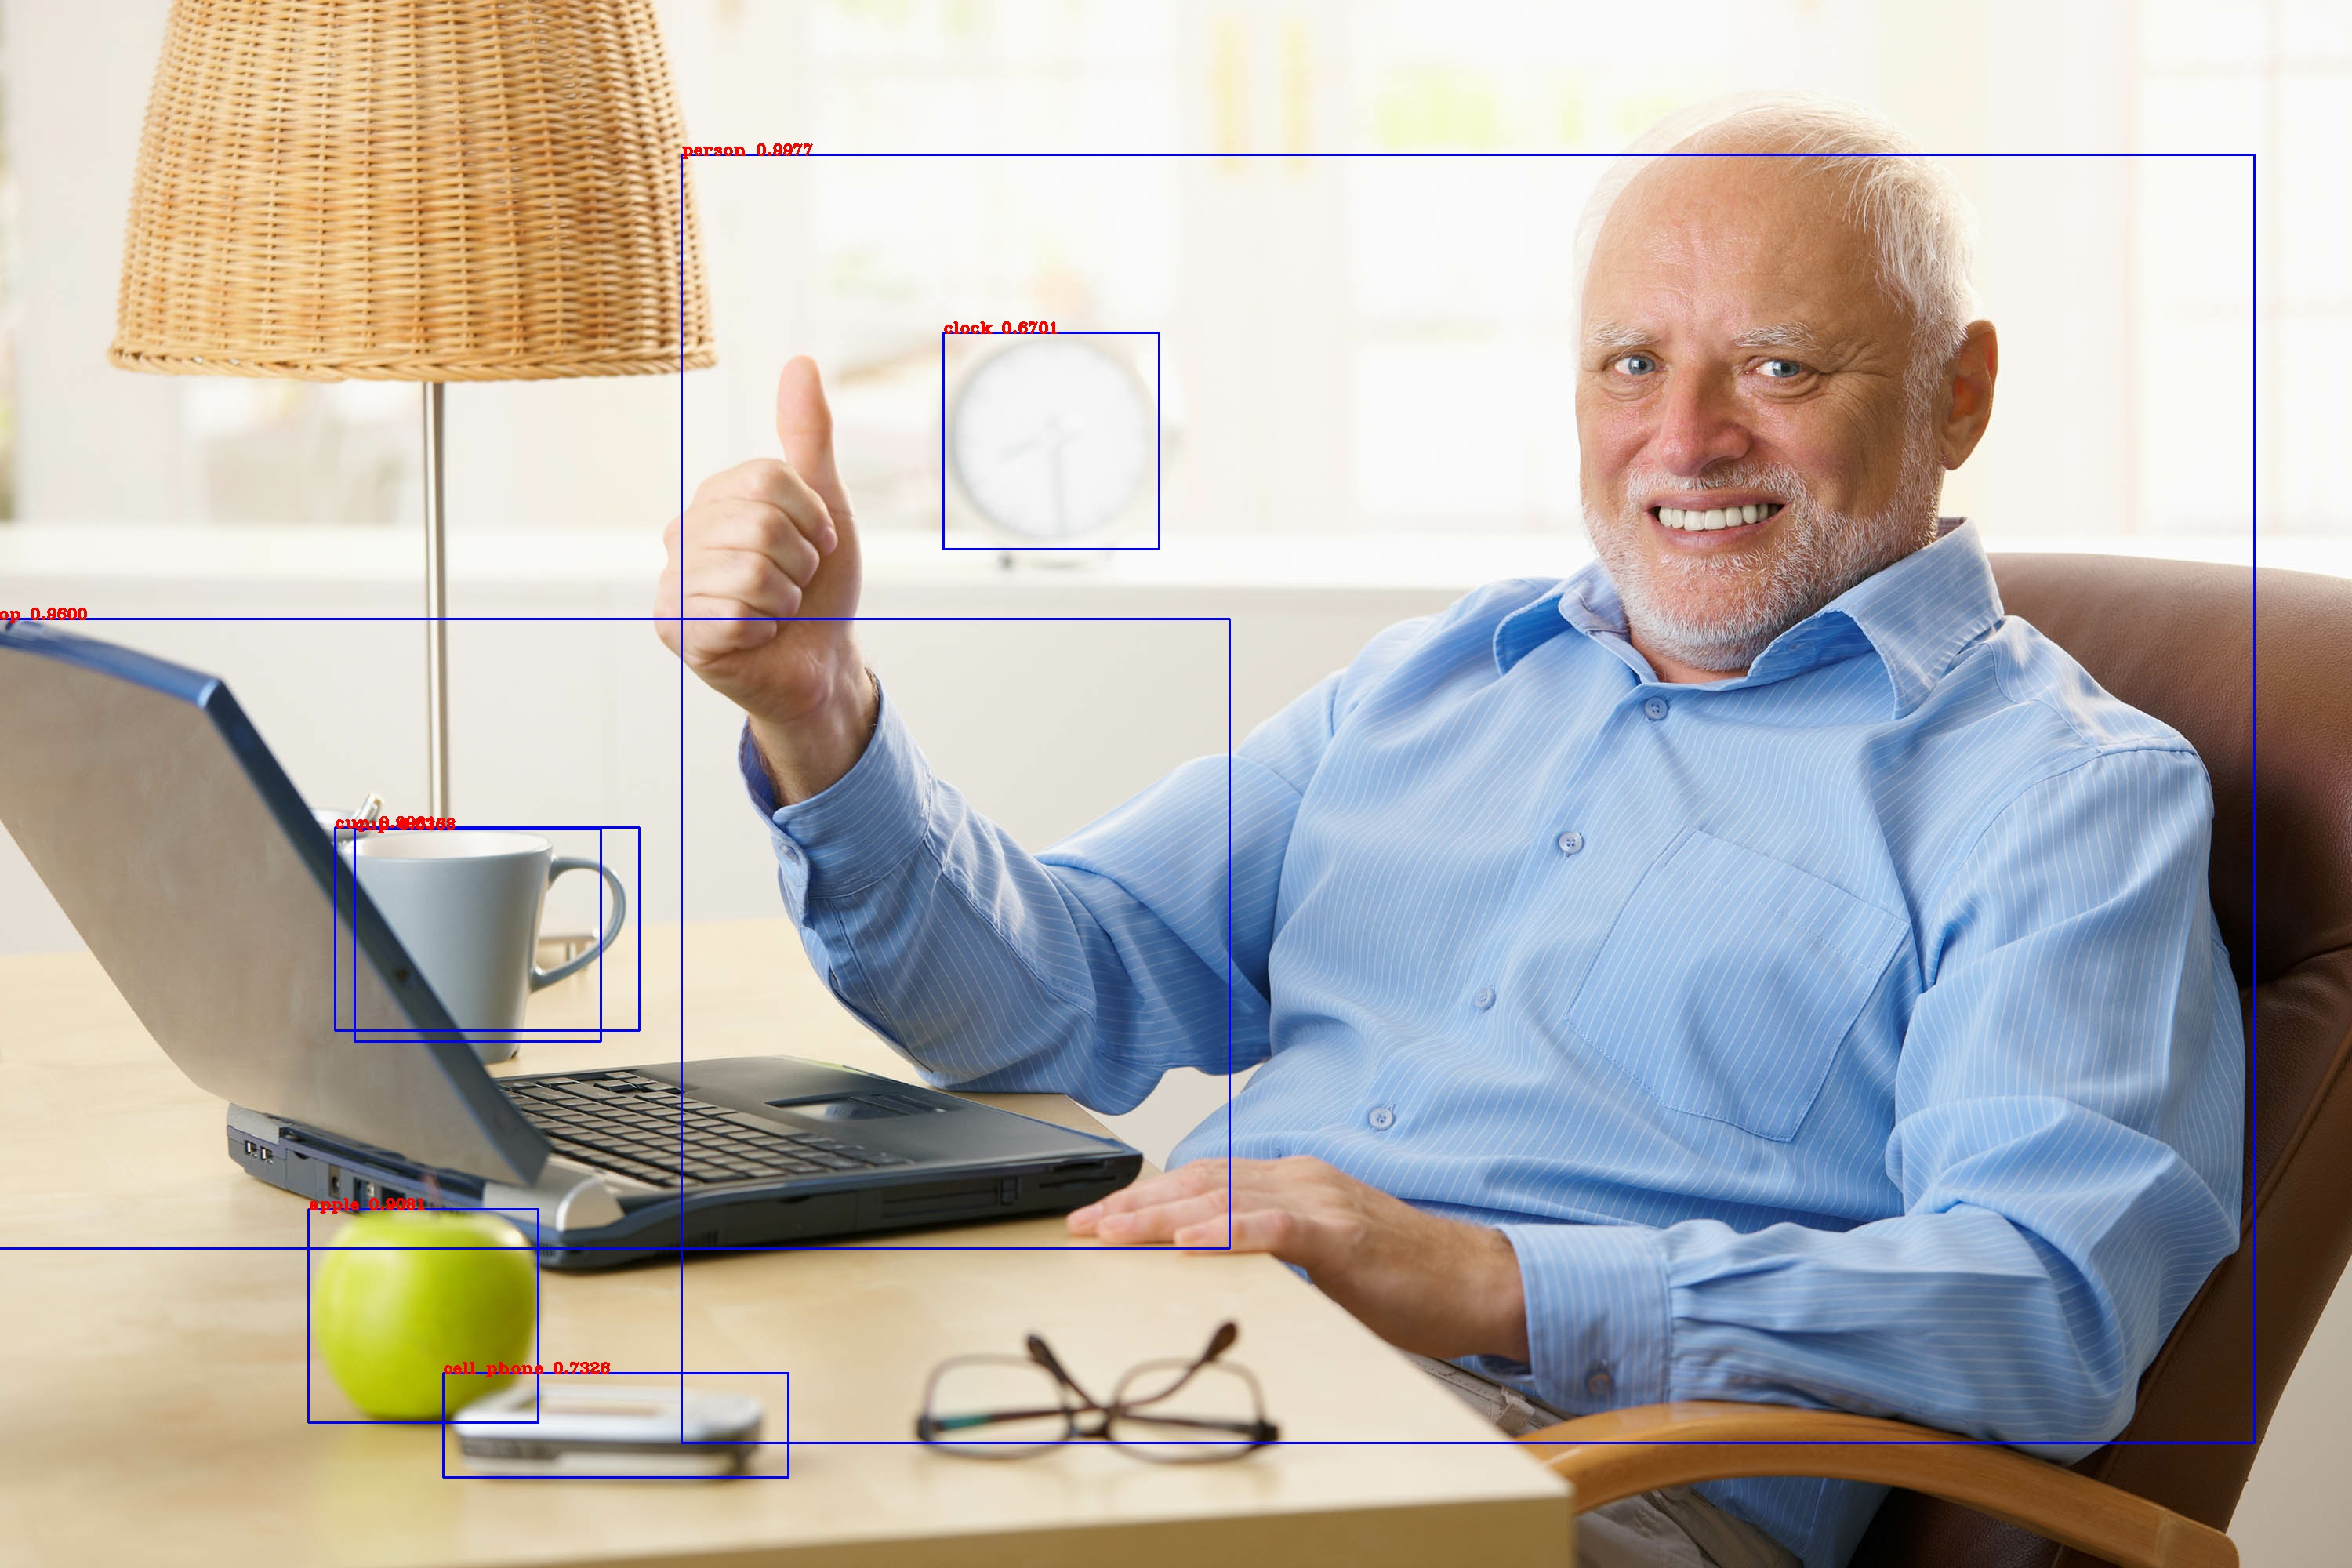

In [13]:
# 탐지 결과 이미지로 표시
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

# Jupyter Notebook에서 이미지 표시
from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

## **4. 신규 학습 진행**

### **4-1. 데이터 전처리**

In [14]:
# raw 데이터(tar) 압축 해제
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

In [15]:
# YOLOv3 학습을 위한 voc2012 학습 데이터 전처리 수행
!python3 tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

# YOLOv3 학습을 위한 voc2012 검증 데이터 전처리 수행
!python3 tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2024-11-27 04:13:30.702287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
ImportError: _multiarray_umath failed to import
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
I1127 04:13:31.167705 128832481556288 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I1127 04:13:31.168379 128832481556288 voc2012.py:97] Image list loaded: 3473
100%|███████████████████████████

In [16]:
!conda install -y -c nvidia cuda-nvcc

Channels:
 - nvidia
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /root/miniconda3/envs/object_detection_env

  added / updated specs:
    - cuda-nvcc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cuda-crt-dev_linux-64-12.6.85|                0          79 KB  nvidia
    cuda-crt-tools-12.6.85     |                0          19 KB  nvidia
    cuda-nvcc-12.6.85          |                0          17 KB  nvidia
    cuda-nvcc-dev_linux-64-12.6.85|                0        10.8 MB  nvidia
    cuda-nvcc-impl-12.6.85     |                0          18 KB  nvidia
    cuda-nvcc-tools-12.6.85    |                0        22.9 MB  nvidia
    cuda-nvcc_linux-64-12.6.85 |                0          20 KB  nvidia
    cuda-nvvm-dev_linux-64-12.6.85|                0          17 KB  nvidia
    cuda-nvvm-impl-12.6.85     |                0      

In [17]:
# 학습 파라미터 설정 및 학습 시작
!python3 train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 8 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2024-11-27 04:13:41.294744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
ImportError: _multiarray_umath failed to import
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
W1127 04:13:44.405629 126582448125760 optimizer.py:122] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
RuntimeError: CPU dispatcher tracer already initlized
RuntimeError: CPU dispatcher tracer already initlized
Epoch 1/3
Instructions for updating:
Use fn_output_signature instead
W1127 04:13:46.224374 126582448125760 deprecation.py:569] From /root/miniconda3/envs

## **5. 신규 학습 weight를 활용한 추론**

In [18]:
FLAGS.num_classes = 20 # 모델이 인식할 클래스 수를 정의
FLAGS.classes = 'data/voc2012.names'  # 클래스 이름이 정의된 파일 경로
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'  # 학습된 가중치 파일 경로
FLAGS.image = 'data/meme.jpg'  # 추론에 사용할 입력 이미지 파일 경로

In [19]:
# 3 epoch로 충분한 학습이 이루어지지 않아 낮은 threshold로 설정 및 추론 진행
FLAGS.yolo_iou_threshold = 0.1  # 예측된 바운딩 박스 간의 IoU 임계값 설정
FLAGS.yolo_score_threshold = 0.1  # 예측된 바운딩 박스의 점수 임계값 설정

In [20]:
# 모델을 YOLOv3 Tiny 또는 기본 YOLOv3로 설정
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)  # YOLOv3 Tiny 모델 초기화
else:
    yolo = YoloV3(classes=FLAGS.num_classes)  # YOLOv3 기본 모델 초기화

# 학습된 가중치 로드
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')  # 가중치가 로드되었음을 로그에 기록

# 클래스 이름을 로드
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')  # 클래스 이름이 로드되었음을 로그에 기록

# 입력 이미지를 읽고 디코딩
img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3
)

# 배치 차원을 추가하여 모델에 맞게 확장
img = tf.expand_dims(img_raw, 0)
# 이미지를 모델 입력 크기로 변환 (예: 416x416)
img = transform_images(img, FLAGS.size)

t1 = time.time()  # 예측 시작 시간 기록
# 이미지에 대해 예측 수행
boxes, scores, classes, nums = yolo(img)
t2 = time.time()  # 예측 종료 시간 기록
logging.info('time: {}'.format(t2 - t1))  # 예측에 걸린 시간 로그에 기록

logging.info('detections:')  # 탐지된 객체를 로그에 기록
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                       np.array(scores[0][i]),
                                       np.array(boxes[0][i])))

I1127 04:16:02.058447 123655761471296 2731513292.py:9] weights loaded
I1127 04:16:02.059006 123655761471296 2731513292.py:13] classes loaded
I1127 04:16:02.153518 123655761471296 2731513292.py:29] time: 0.07336091995239258
I1127 04:16:02.153911 123655761471296 2731513292.py:31] detections:
I1127 04:16:02.155972 123655761471296 2731513292.py:33] 	person, 0.680701732635498, [0.21452692 0.22743443 0.96779203 0.89759505]
I1127 04:16:02.157679 123655761471296 2731513292.py:33] 	person, 0.31014204025268555, [0.22656193 0.21729416 1.0693927  0.9028767 ]
I1127 04:16:02.159243 123655761471296 2731513292.py:33] 	person, 0.1431206464767456, [0.24417609 0.16284823 0.94446284 0.83859074]


I1127 04:16:02.268591 123655761471296 231062041.py:7] output saved to: ./output.jpg


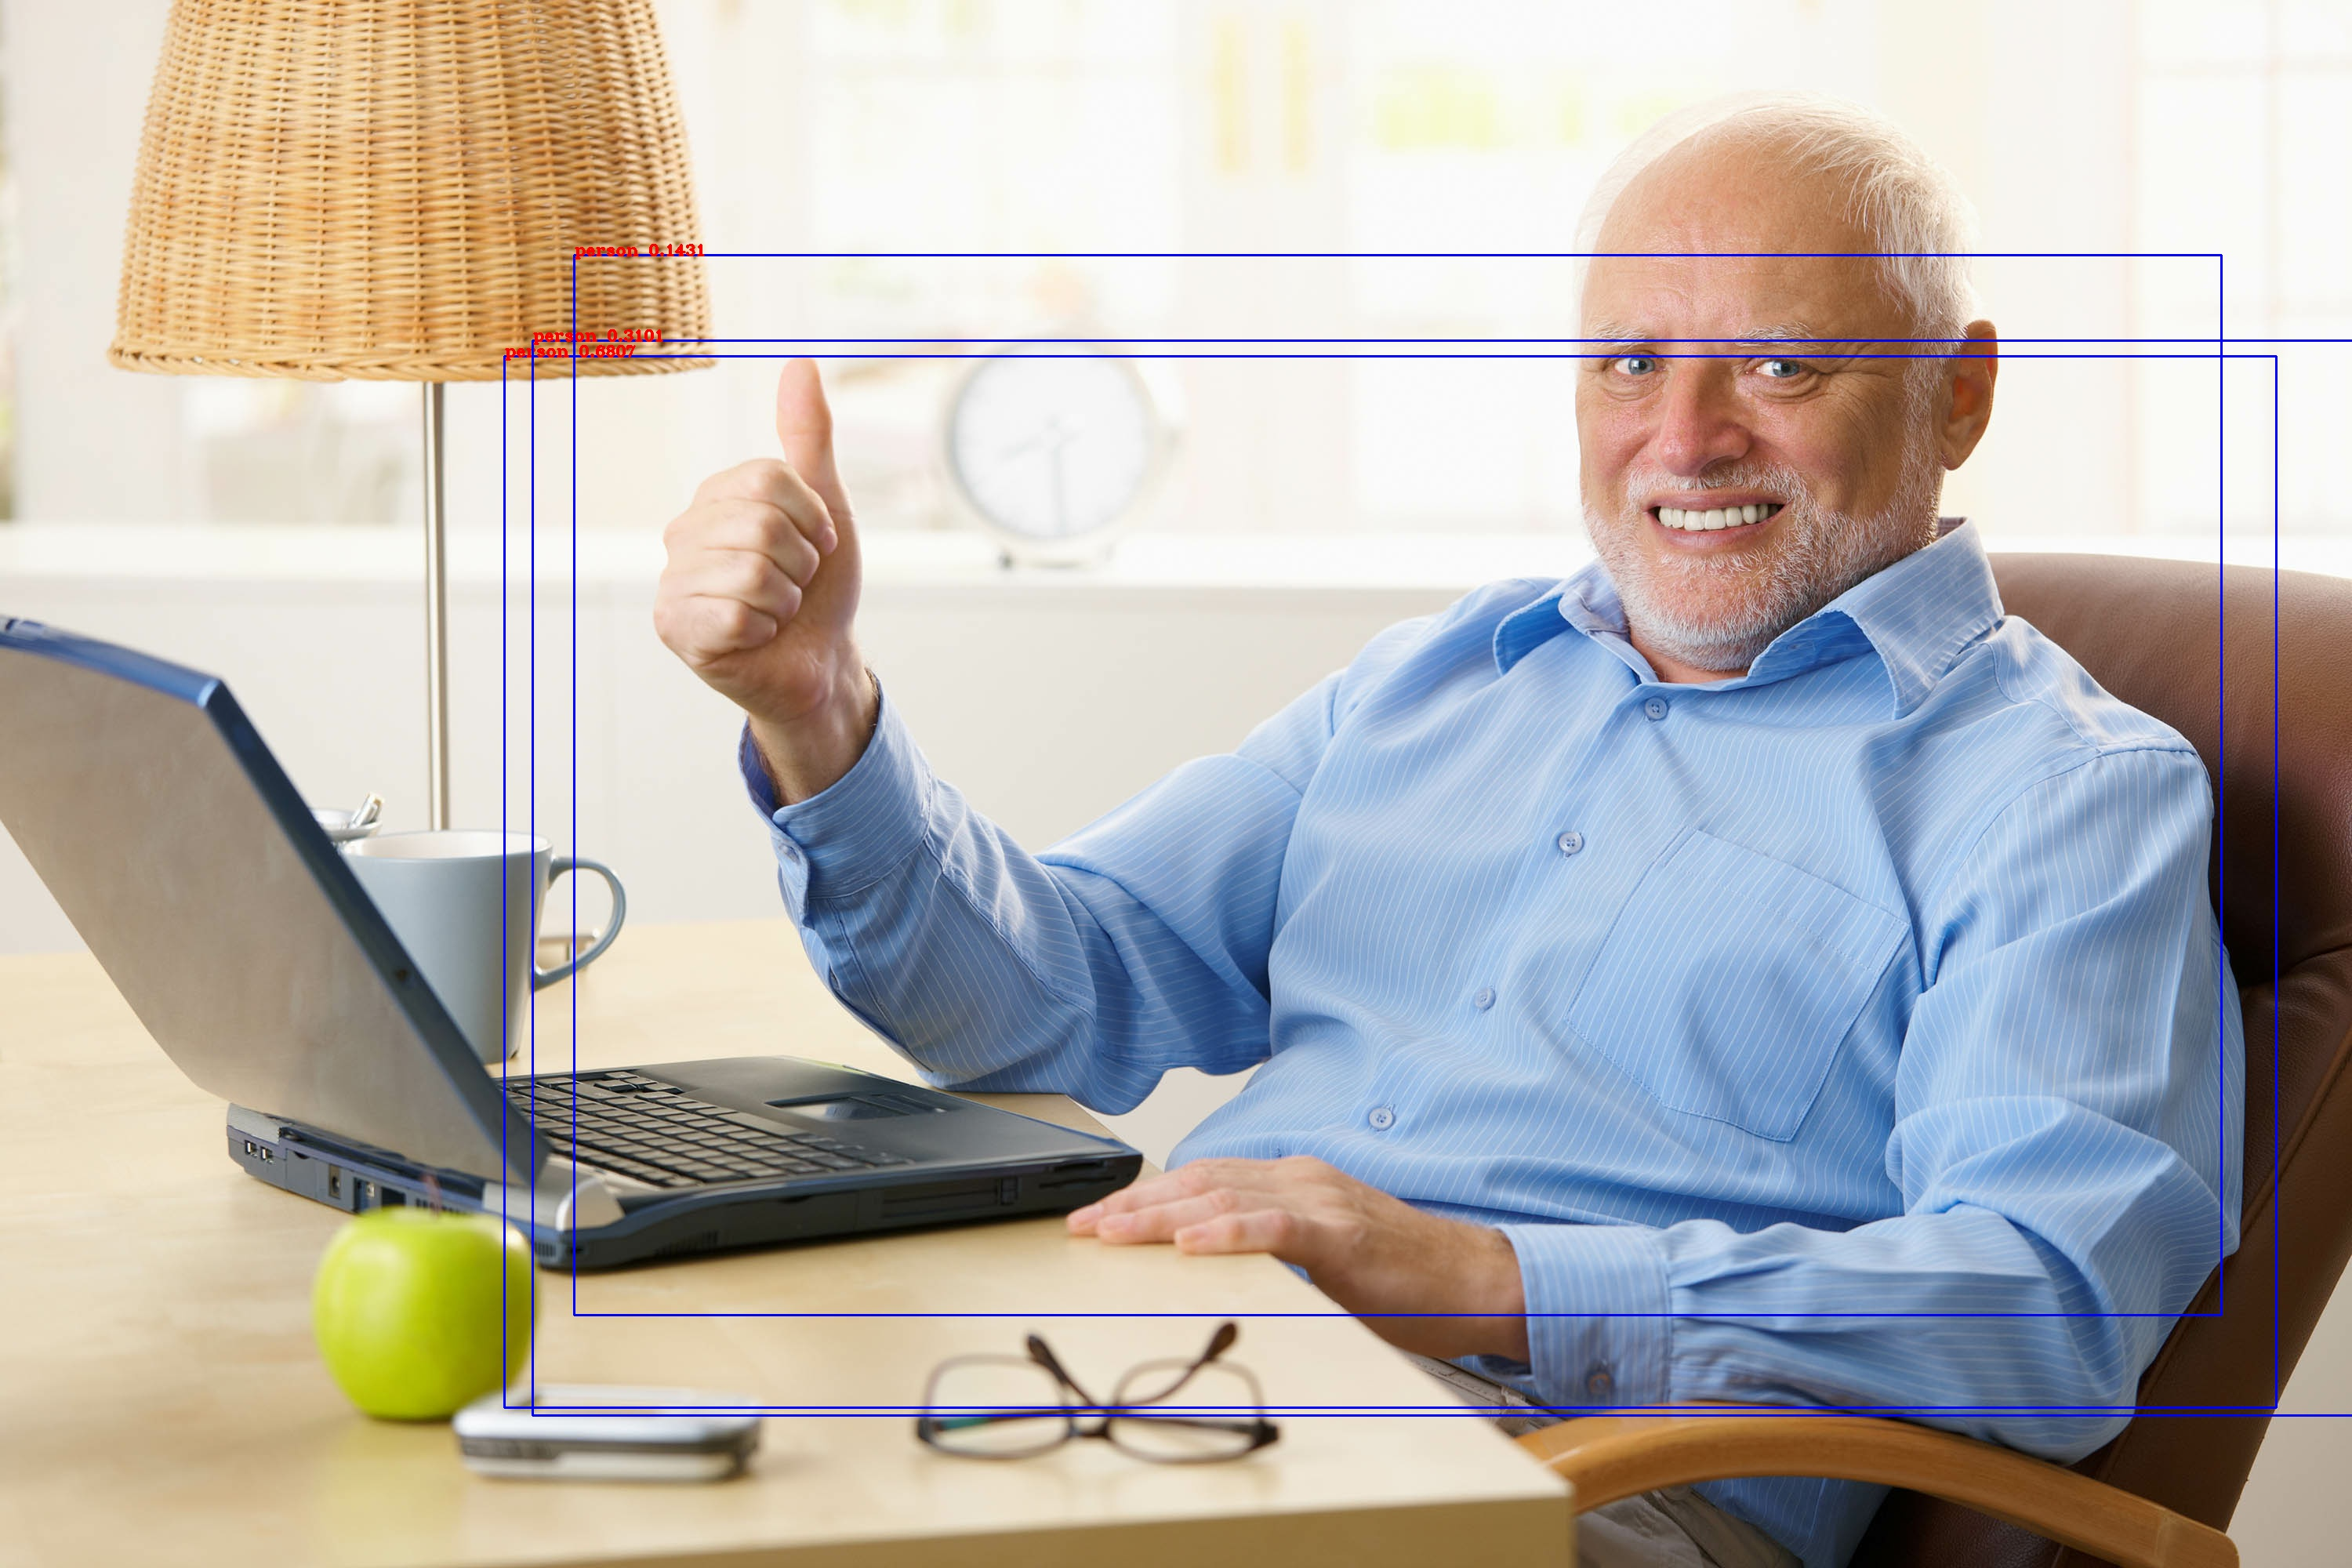

In [21]:
# 이미지 색상 변환 (RGB에서 BGR로 변환하여 OpenCV에서 사용)
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
# 예측된 바운딩 박스와 클래스 이름을 이미지에 그림
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
# 결과 이미지를 파일로 저장
cv2.imwrite(FLAGS.output, img)
logging.info('output saved to: {}'.format(FLAGS.output))  # 결과 이미지 저장 로그

# Jupyter Notebook에서 이미지를 표시
from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))